In [4]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
import seaborn as sns
import myFunctions as fct
import matplotlib as mpl
import scipy.io as sio
from autoEncoderDense import AutoEncoderDense
from sklearn.model_selection import KFold
from tensorflow.keras import backend

In [5]:
adhd= np.load('ucla_adhd_dbs80_filtered.npy')
bipolar= np.load('ucla_bipolar_dbs80_filtered.npy')
schizophrenia= np.load('ucla_schizophrenia_dbs80_filtered.npy')
controls= np.load('ucla_controls_dbs80_filtered.npy')
                

matrix_list = []

for i in range (40):
    matrix_list.append(controls[i])


for i in range (40):
    matrix_list.append(bipolar[i])
    
n = adhd.shape[0]
for i in range (n):
    matrix_list.append(adhd[i]) 


for i in range (40):
    matrix_list.append(schizophrenia[i])            
matrix_array = np.stack(matrix_list, axis=0)


num_matrices = matrix_array.shape[0]
shuffled_indices = np.random.permutation(num_matrices)
all_data = np.zeros_like(matrix_array)
for i, index in enumerate(shuffled_indices):
    all_data[i] = matrix_array[index]

print(all_data.shape)

assert matrix_array[0][0][0] != all_data[0][0][0]

all_data_normalized = all_data

(160, 80, 152)


In [10]:
import dataframe_image as dfi
df = pd.DataFrame(all_data_normalized[1])
dfi.export(df, 'df80_styled.png', max_cols = 5, max_rows = 8, dpi = 800)

(192, 80, 152, 1)
dataset shape (29184, 80, 1, 1)
Train idx = [    0     1     2 ... 29181 29182 29183] test idx = [    3     9    15 ... 29161 29165 29167]
training set size=(23347, 80, 1, 1)
test set size=(5837, 80, 1, 1)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 80, 1, 1)]        0         
_________________________________________________________________
encoder_layer_0 (Dense)      (None, 80, 1, 80)         160       
_________________________________________________________________
encoder_bn_0 (BatchNormaliza (None, 80, 1, 80)         320       
_________________________________________________________________
encoder_layer_1 (Dense)      (None, 80, 1, 60)         4860      
_________________________________________________________________
encoder_bn_1 (BatchNormaliza (None, 80, 1, 60)         240       
_________________________________

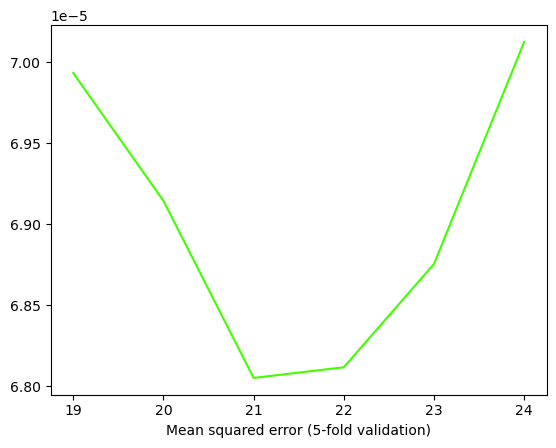

In [27]:
# Define constant parameter values for training
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 25

# Load your data, dimensions are:
# *Datasets sizes* sz[0] = num_subjects / sz[1] = num_ROIs / sz[2] = num_timepoints
# Dataset is called all_data here
# Timestep
dt = 2  # in seconds

sz_all = all_data_normalized.shape


# This is how I built the data sets for test and training, "dataset" is your data, "chunk_siz" is the time window we
# talked about (~0.8-1sec for you --> you have to put it in number of frames),
# "train_prop" is the training vs test ratio

def build_training_test_sets(dataset, chunk_siz=1, train_prop=0.9):
    dataset = dataset.reshape(dataset.shape + (1,))
    sz_dat = dataset.shape
    print(sz_dat)
    tot_patients = sz_dat[0]
    num_chunks = int(np.floor(sz_dat[2]/chunk_siz))
    num_train_patients = int(np.floor(tot_patients*train_prop))
    x_train = np.empty([num_train_patients*num_chunks, sz_dat[1], chunk_siz, 1])
    x_test = np.empty([(tot_patients-num_train_patients)*num_chunks, sz_dat[1], chunk_siz, 1])
    for chunk_idx in range(0, num_chunks-1):
        # Take num_train_patients patients randomly in time chunk chunk_idx and add them to the training
        patients_to_add = np.random.choice(tot_patients, size=num_train_patients, replace=False)
        other_patients = np.delete(range(0, tot_patients), patients_to_add, axis=0)
        x_train[chunk_idx*num_train_patients:(chunk_idx+1)*num_train_patients, :, :] = \
            dataset[patients_to_add, :, chunk_idx*chunk_siz:(chunk_idx+1)*chunk_siz, :]
        x_test[chunk_idx*(tot_patients-num_train_patients):(chunk_idx+1)*(tot_patients-num_train_patients), :, :] = \
            dataset[other_patients, :, chunk_idx*chunk_siz:(chunk_idx+1)*chunk_siz, :]
    return x_train, x_test

# This is to train the AE
def train(x_train, x_valid, learning_rate, batch_size, epochs, latent_dim=10, chunk_siz=60):
    autoenc = AutoEncoderDense(
        input_size=[80, chunk_siz, 1],
        layers_dim=[80, 60, 20],
        latent_space_dim=latent_dim
    )
    autoenc.summary()
    autoenc.train(x_train, x_valid, learning_rate, batch_size, epochs)
    return autoenc


if __name__ == "__main__":
    # Define data set
    dataset, x_test = build_training_test_sets(all_data_normalized, 1, 1)
    sz_dat = dataset.shape
    print(f"dataset shape {sz_dat}")

    mean_val_mse = []
    mean_val_acc = []

    latdim_range = range(19, 25, 1) #change
    for lat_dim in latdim_range:
        VALIDATION_ACC = []
        VALIDATION_MSE = []

        # K-fold validation datasets
        k = 5
        kf = KFold(n_splits=k, shuffle=True, random_state=None)
        fold_iteration = 1
        for train_idx, test_idx in kf.split(dataset):
            print(f"Train idx = {train_idx} test idx = {test_idx}")
            x_train = dataset[train_idx, :, :, :]
            x_valid = dataset[test_idx, :, :, :]
            print(f"training set size={x_train.shape}")
            print(f"test set size={x_valid.shape}")

            # Training step # fold_iteration/k
            save_dir = "KFOLD_validation"

            autoencoder = train(x_train, x_valid, LEARNING_RATE, BATCH_SIZE, EPOCHS, lat_dim, 1)
            autoencoder.save(save_dir, f"model_{fold_iteration}_{lat_dim}")
            autoencoder.save_encoder(save_dir, f"encoder_{fold_iteration}_{lat_dim}")

            autoencoder_trained = AutoEncoderDense.load(save_dir, f"model_{fold_iteration}_{lat_dim}")
            autoencoder_trained.summary()
            weights = autoencoder_trained.get_weights()

            encoder_trained = AutoEncoderDense.load_encoder(save_dir, f"encoder_{fold_iteration}_{lat_dim}")
            encoder_trained.summary()
            encoder_weights = encoder_trained.get_weights()

            # Evaluate the performance of the model - VALIDATION SET
            x_predict = autoencoder_trained.predict(x_valid)
            results = autoencoder_trained.evaluate(x_predict, x_valid)

            print(f"MSE results: {results[1]}")
            print(f"accuracy results: {results[2]}")
            print(f"metrics names {autoencoder_trained.metrics_names}")

            VALIDATION_MSE.append(results[1])
            VALIDATION_ACC.append(results[2])

            backend.clear_session()

            fold_iteration += 1
            print(f"fold iteration # {fold_iteration}  lat dim {lat_dim}")
            print(f"MSE (valid) {VALIDATION_MSE}, lat dim {lat_dim}")

        mean_val_mse.append(np.mean(VALIDATION_MSE))
        mean_val_acc.append(np.mean(VALIDATION_ACC))

    # Save results evaluation for matlab
    sio.savemat(save_dir + f"/validation_mse_{lat_dim}.mat", mdict={'validation_MSE': mean_val_mse})
    sio.savemat(save_dir + f"/validation_acc_{lat_dim}.mat", mdict={'validation_acc': mean_val_acc})

    colors_data_points = plt.cm.gist_rainbow(np.linspace(0, 1, 103))
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(latdim_range, mean_val_mse, color=colors_data_points[36])
    ax.set_xlabel("Latent dimension")
    ax.set_xlabel(f"Mean squared error ({k}-fold validation)")
    plt.show()